# "Logistic Regression"
> "My reference notebook for the logistic regression model."

- author: Christopher Thiemann
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [statistics, machine learning, regression]
- hide: false
- search_exclude: true
- image: images/logistic_regression.png

In [2]:
#hide
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import bernoulli
from scipy.optimize import minimize_scalar
import pandas as pd
import statsmodels.api as sm
from sklearn.calibration import calibration_curve
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Motivation

Often one has to work with binary data, e.g. in fraud detection, bought a product vs. not bought,... The question is how to model this type of data. As we will see the naive idea of using a linear regression model is not well suited. 

## The Model

The short answer is that the logistic regression model is a glm with logit link function (99.999% of the time its logit) ad Bernoulli Distribution.

One way modeling binary data is to model it as if were drawn from a *bernouli* distribution. So if our data takes on values $y_i \in \{0,1\}$ for all $i=1,...,n$ Hence 

$y_i \sim Ber(\pi_i)$

as usual on the GLM setting we model the mean $\pi_i$ as linear combination of the explanatory data $x_1,...,x_n$

$\pi_i=p(y_i = 1 | X=x_i, \beta)=\beta_0 + \beta_1 x_{i1} + ... + \beta_p x_{ip}$.
Note $E(y_i)=\pi_i$ Further note that the systematic component is not restricted, meaning it can take on values outside the range of $[0, 1]$. This motivates to constrain the linear component by first passing it through a function which maps values to $[0, 1]$ (there are also problems with heteroscedasticity). The most used function is the sigmoid.

$f(x) = \frac{1}{1 + e^{-x}}$

Hence we model

$p(y_i = 1 | X=x_i, \beta)=f(\beta_0 + \beta_1 x_{i1} + ... + \beta_p x_{ip})=f(x_i' \beta)$


### Odds

We can rewrite the model as follows

$\pi_i + e ^{-x_i'\beta} \pi_i = 1$

$e ^{-x_i'\beta} = \frac{1 - \pi_i}{\pi_i}$

$x_i'\beta = - ln(\frac{1 - \pi_i}{\pi_i}) = ln(\frac{ \pi_i}{1 - \pi_i})$

Define $\frac{ \pi_i}{1 - \pi_i}$ as *Odds* with this we have a linear model for the odds with a log link function. This will later help in interpreting the coefficients.

$ln(Odds_i)=x_i'\beta$

### Estimation

#### The loss function

We can estimate the coeficients of interest via maximum likelihood. If $y_i$ is iid for all obersavtions we can use as the the negative of the maximum likelihood function as loss function

$L= \Pi_i \pi_i^{y_i} (1 - \pi_i)^{1-y_i}$

the log of the likelihood function is

$-ln(L) =: Loss(\beta) = - \sum_i [ y_i ln(\pi_i)+(1- y_i) ln(1 - \pi_i)]$



#### Gradient

One can show that the gradient of the loss is given by

$Loss'(\beta) = X'(\pi-y)$

don't forget that $\beta$ is hidden in $\pi$ i.e. $\pi_i = sigmoid(x_i' \beta)$ for all $i=1,...,n$


#### Hessian

The Hessian is given

$\frac{\partial^2 Loss(\beta)}{\partial \beta' \partial \beta} = X'SX$

where $S=diag(\pi_i(1-\pi_i))$ for $i=1,...,n$

#### Convexity

One can show that the hessian is positve definite and hence if we find a minimum of the loss we can be sure that it is also the global minimum.

#### Gradient descent

For an implementation see the helper functions section.

#### IRLS

For an implementation see the helper functions section.

### Assumptions

#### Linear Seperability

One of the assumptions is that the target is not *linear seperable* by the features. That means there is a feature $x$ and threshold such that we can perfectly classify the target by a rule such as for all the data less than the threshold i.e. $y = 1(x> threshold)$ we know it is $y=0$ and above $y=1$ and hence we dont need a model at all. In the a two dimensional case the sigmoid converges to the indicator function and in the limit $\beta_1 -> \infty$. One way to counter this effect is to all regularization to the model.

Consider the example below

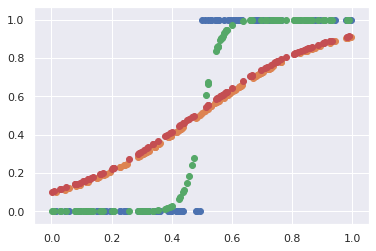

In [5]:
np.random.seed(123)

for i in [2, 5]:
    
    x = np.random.rand(100)
    
    y = np.where(x < .5, 1, 0)


    y[1:i] = 1

    x = x.reshape(-1, 1)

    model = LogisticRegression(fit_intercept = True, penalty = 'none').fit(x, y)


    plt.scatter(x, model.predict_proba(x)[:, 0])
    
    model = LogisticRegression(fit_intercept = True, penalty = 'l2').fit(x, y)


    plt.scatter(x, model.predict_proba(x)[:, 0])




### Interpretation

The problem with interpreting the coefficients is that the model is nonlinear. That means we can't just say if variable $x_1$ increases by 1 then $y$ increases by $\beta_1$. Due to the non linearities this effect depends on on the values of the other variables $x_2,...,x_p$ and hence the effect is different for each observation. In the real world application we will see how to interpret the coeficients with the already introduced Odds.

## Real world example

As toy data set I am going to use the [palmer penguins data](https://github.com/allisonhorst/palmerpenguins). 

### Load Data

In [ ]:
%%R
library(palmerpenguins)

In [94]:
df = %R penguins
df.dropna(inplace = True)
df.drop(columns = ['year', 'sex'], inplace = True)
df['constant'] = 1
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,constant
1,Adelie,Torgersen,39.1,18.7,181,3750,1
2,Adelie,Torgersen,39.5,17.4,186,3800,1
3,Adelie,Torgersen,40.3,18.0,195,3250,1
5,Adelie,Torgersen,36.7,19.3,193,3450,1
6,Adelie,Torgersen,39.3,20.6,190,3650,1


Since there are 3 species (3 classes in logistc regression language) I will do a one vs. all approach to stay in the binary world. In the following I will find a suitable "target".

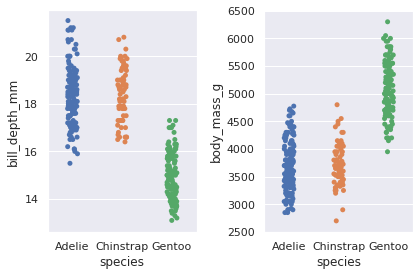

In [41]:
#hide_input
fig, axes = plt.subplots(1, 2, tight_layout = True)
sns.stripplot(x = 'species', y = 'bill_depth_mm', data = df, ax = axes[0])
sns.stripplot(x = 'species', y = 'body_mass_g', data = df, ax = axes[1]);

Seems we will get some meaningful results if we code Gentoo = 1 and Adelie and Chinstrap = 0.

In [95]:
mask = df.species == 'Gentoo'
df.species = df.species.astype(object)
df.species = np.where(mask, 1 , 0)

### Linear Seperable

Let's try out the following model...

In [107]:
model = sm.GLM(df.species, df[['constant', 'body_mass_g', 'bill_depth_mm']], family = sm.families.Binomial())
sume = model.fit()
print(sume.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                species   No. Observations:                  333
Model:                            GLM   Df Residuals:                      330
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                 Mi, 02 Sep 2020   Deviance:                          nan
Time:                        11:17:28   Pearson chi2:                 2.32e-14
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
constant        186.6889   4.61e+07   4.05e-06

Look at the standard errors and confidence intervalls, they blew up! What happend ?

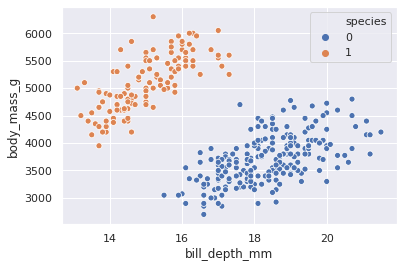

In [109]:
#hide_input
sns.scatterplot(x = 'bill_depth_mm', y= 'body_mass_g', hue = 'species', data = df);

We ran into an example where the features are perfectly seperable by a line. Look at the plot above and remember that species = 1 is Gentoo.

By the way, can you spot the simpson paradox in the above plot ?

### Interpreting coefficents

Let's fit the model 

$logit(Odds_i) = \beta_0 + \beta_1 \text{body_mass_g}_i $

In [137]:
model = sm.GLM(df.species, df[['constant', 'bill_depth_mm']], family = sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                species   No. Observations:                  333
Model:                            GLM   Df Residuals:                      331
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44.865
Date:                 Mi, 02 Sep 2020   Deviance:                       89.729
Time:                        13:41:30   Pearson chi2:                     126.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
constant         53.1168      7.658      6.936

We found that $\hat{\beta}_1 = 0.0065$

Say we have Odds for some observation is $2$ meaning it is twice as liekli to e of species Gentoo. Now if we increase the bill depth by 1mm then this will reduce the odds by $exp(-3.254) \approx 4 $%

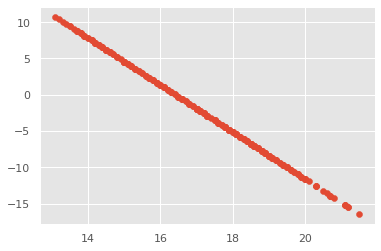

In [156]:
prob_one = model.predict(df[['constant', 'bill_depth_mm']])

odds = prob_one / (1 - prob_one)

log_odds = np.log(odds)

plt.scatter(df.bill_depth_mm, log_odds);

### Probability Calibration

The probabilities are well calibrated in the logistic regression.

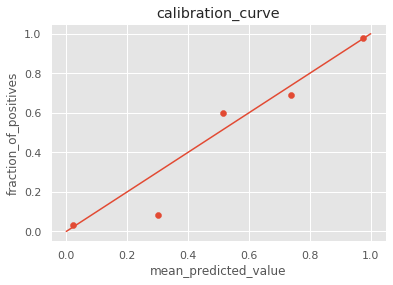

In [155]:
fraction_of_positives, mean_predicted_value = calibration_curve(df.species, prob_one)

plt.scatter(mean_predicted_value , fraction_of_positives)
plt.plot([0 , 1], [0, 1])

plt.title("calibration_curve")
plt.xlabel("mean_predicted_value")
plt.ylabel("fraction_of_positives");

## Helper Functions

In [3]:
def sigmoid(x):
    
    pi = 1 / (1 + np.exp(-x))
              
    pi = np.clip(pi, .000001, .999999)
        
    return pi

def grad(beta, X, y):
        
    pi = sigmoid(X @ beta)
        
    return 1 / X.shape[0] * X.T @ (pi - y)

def hessian(X, pi):
    
    S = np.diag(pi)
    
    return X.T @ S @ X

def cross_entropy(beta, y, X):
    
    pi = sigmoid(X @ beta)
        
    return - 1 / X.shape[0] * np.sum(y * np.log(pi) + (1-y) * np.log(1 - pi))


def gradient_descent(X, y):
    
    n, p = X.shape
    
    beta = np.zeros(p)

    for i in range(100):
        
        
        gradient = grad(beta, X, y)
        
        res = minimize_scalar(lambda x: cross_entropy(beta - np.exp(x) * gradient, y, X))
        
        beta_proposal = beta - np.exp(res.x) * gradient
        
        if np.abs(beta_proposal - beta).sum() < .0000001:
            print(i)
            break
        beta = beta_proposal
        
    return beta

def IRLS(X, y):
    
    n, p = X.shape
    
    beta = np.zeros(p)
        
    for i in range(1000):
        
        
        eta =  X @ beta
        
        pi = sigmoid(eta)
                
        s = pi * (1 - pi)
        
        S = np.diag(s)
        
        z = X @ beta +  (y - pi) * 1 / s
        
        
            
        beta_proposal = np.linalg.inv(X.T @ S @ X) @ X.T @ S @ z
           
        if np.abs(beta_proposal - beta).sum() < .0000000001:
            
            print(i)
            break
            
            
        beta = beta_proposal
        
        
    return beta
        
        
    
    
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler



np.random.seed(122)
X, y = load_breast_cancer(return_X_y = True)

#X = X[:, 1 : 3] # only take subset because p is quite large hance need regularization to avoid num. instability

X = np.random.randn(len(y), 5)

bb = gradient_descent(X, y)
#bb = IRLS(X, y)
test = LogisticRegression(fit_intercept = False, penalty = 'none').fit(X, y)

print(bb.round(3), test.coef_.round(3))

7
[ 0.051  0.108 -0.009  0.086 -0.069] [[ 0.051  0.108 -0.009  0.086 -0.069]]


## To do list

- rare events
- more than two classes
- theory
- simulations
- extensions
 - bayes
 - kernelized
 - regularized
- Latent variable interpretation
- add Online learning to estimation section

## Plot for the Blog Post

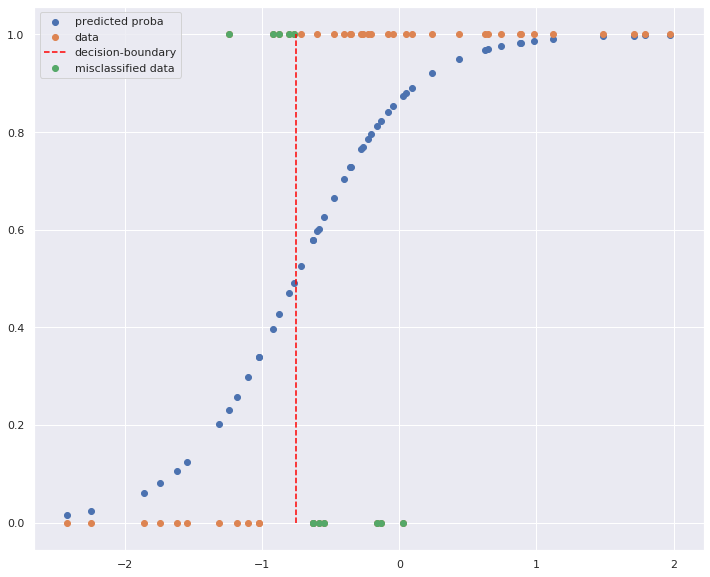

In [4]:
#collaps
model = LogisticRegression(penalty = 'none')
np.random.seed(3)
X = np.random.randn(50, 1)
X = np.concatenate([np.ones(50).reshape(-1, 1), X], axis = 1)
beta = np.array([2, 3])

eta = X @ beta

mu = sigmoid(eta)

Y = bernoulli.rvs(mu)

model.fit(X, Y)

fig, axes = plt.subplots(figsize = (12, 10))
axes.scatter(X[:,1], model.predict_proba(X)[:, 1], label = 'predicted proba')
axes.scatter(X[:,1],Y, label = 'data')
axes.vlines(-.75, 0, 1, color = 'red', linestyle = 'dashed', label = 'decision-boundary')


mask = model.predict(X) != Y
axes.scatter(X[:,1][mask], Y[mask], label = 'misclassified data')

axes.legend()


fig.savefig("logistic_regression.png");




## References

### Sources

Chapter 7 of {% cite murphy2012machine %} - General Information

{% bibliography --cited %}